In [1]:
import pandas as pd
import matplotlib.pyplot as plt

We developed a large variety of methods to trace field lines.  In the compare_methods_same notebook, we showed that some methods are equivalent.  Here we explore the remaining methods that should produce similar, but not necessarily identical results.  We show that these methods produce similar results, but there are areas where the results differ.

We implemented the following methods:

- BATSRUS SCIPY - Reads a BATSRUS file and determines field lines using SCIPY interpolator and solve_ivp
- BATSRUS SWMFIO - Same as BATSRUS SCIPY except it uses the SWMFIO interpolator
- VTK SCIPY - Same as BATSRUS SCIPY except it reads a VTK file and uses a VTK routine to determine cell centers (Note 1).
- VTK SCIPY (CC) - Same as VTK SCIPY except the cell centers are read from the VTK file (Note 1).
- VTK PARA - Uses VTK file and determines field lines with paraview.simple StreamTracer.

As shown in compare_methods_same, BATSRUS SCIPY, VTK SCIPY, and VTK SCIPY (CC), which use the same algorithm to calculate field lines, produce identical field lines when supplied with the same data.  So in this notebook, we compare BATSRUS SCIPY, BATSRUS SWMFIO, and VTK PARA, which use different algorithms, but should generate similar, but not necessarily identical, field lines. 

Note 1.  In a BATSRUS file, a grid is defined and the field is given at each grid point.  In a VTK file, the grid specifies the corners of the cells, and the field is given at each cell center.  The SWMFIO conversion from BATSRUS to VTK takes this into account, and will record the original BATSRUS grid, which corresponds to the cell centers in the VTK file.  Thus the VTK methods can calculate the cell centers from the VTK grid or can use the cell centers stored in the VTK file, leading to the two methods VTK SCIPY and VTK SCIPY (CC).

In [2]:
# Read results from magfli using the various methods outlined above
results = pd.read_pickle("compare_methods.pkl")

The previous notebook, compare_methods_same, defines many of the columns contained in the dataframe we read with the above python code.  Here, we focus on the additional columns that we use in this analysis.

The compare_methods.py script calculates the arc length of each field line.  The columns containing the arc lengths end in ...Arc Length_0, Arc Length_1, etc., corresponding to the four field lines.  The arc length at the first point in the field line is 0, sine we are at the begining of the field line.  The arc length at the second point is 0 plus the distance between the 1st and 2nd point, ..., the arc length at point n+1 is the total arc length to point n plus the distance between points n and n+1.  

In addition, compare_methods.py calculates the differences between the fieldlines generated by the various methods.  These results are stored in columns with headings like BATSRUS SCIPY VTK PARA Delta_0, which contains the scalar distances between the field lines from the BATSRUS SCIPY and the VTK PARA methods.  To determine the differences, the python script is given two field lines calculated with two different methods, along with the arc lengths for both field lines.  The python script marches down each field line.  At the first point on both field lines the scalar distance between them is always zero because both field lines start at the same point.  The python script marches a short distance down both field lines, $\delta$.  At this second point, the scalar distance between two points is determined.  Repeat until the end of the field line is reached. If the two methods that generated the fieldlines give identical results, the scalar distances are zero everywhere.  

Finally, the dataframe contain columns with the magnitude of the magnetic field and the size of the grid cells.  The field magnitude is determined either with the BATSRUS SCIPY interpolation routine or the BATSRUS SWMFIO interpolation routine.  The column names follow the naming convention discussed above.

In [3]:
# To see all columns in the compare_methods.pkl dataframe, uncomment the lines below

#for i in results.columns:
#    print(i)

We expect, given the same data, that BATSRUS SCIPY and BATSRUS SWMFIO will generate similar, but not identical, field lines.  Both methods use the SCIPY solve_ivp integrator to determine field lines, but BATSRUS SCIPY uses the SCIPY nearest neighbor interpolator while BATSRUS SWMFIO uses the SWMFIO linear interpolator.  We see broad similarities in the plots below, and a concerning difference in the fourth field line.

In the plots below, the difference between the BATSRUS SCIPY field line and the BATSRUS SWMFIO field line are  plotted against the arc length of the field line.  BATSRUS SCIPY BATSRUS SWMFIO Delta_0 is the difference for the first field line, ...Delta_1 for the second,, etc.  For the first three lines the difference is small, on the order of 0.001.  However, in the fourth field line, the differences starts small, but grows significantly after the arc length reaches 60.

<AxesSubplot:xlabel='BATSRUS SCIPY BATSRUS SWMFIO Delta Arc Lengths_3'>

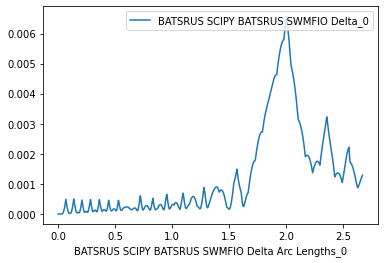

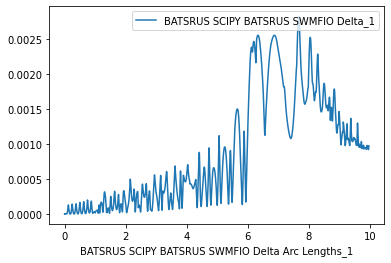

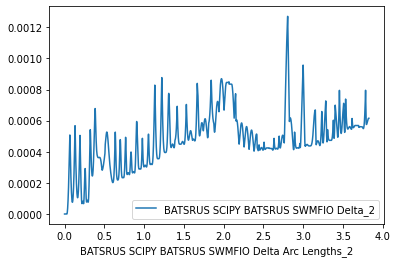

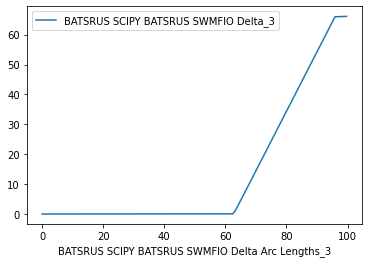

In [4]:
results.plot('BATSRUS SCIPY BATSRUS SWMFIO Delta Arc Lengths_0','BATSRUS SCIPY BATSRUS SWMFIO Delta_0')
results.plot('BATSRUS SCIPY BATSRUS SWMFIO Delta Arc Lengths_1','BATSRUS SCIPY BATSRUS SWMFIO Delta_1')
results.plot('BATSRUS SCIPY BATSRUS SWMFIO Delta Arc Lengths_2','BATSRUS SCIPY BATSRUS SWMFIO Delta_2')
results.plot('BATSRUS SCIPY BATSRUS SWMFIO Delta Arc Lengths_3','BATSRUS SCIPY BATSRUS SWMFIO Delta_3')

In the plot below, the region below arc lengths of 60 is expanded, and we see in that region that the differences are an order of magnitude larger than what we saw above for the first three field lines. 

<AxesSubplot:xlabel='BATSRUS SCIPY BATSRUS SWMFIO Delta Arc Lengths_3'>

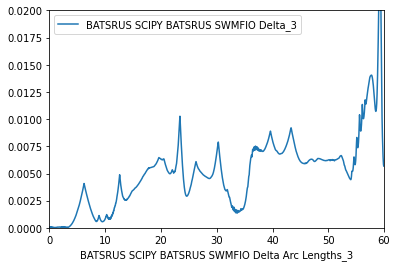

In [5]:
results.plot('BATSRUS SCIPY BATSRUS SWMFIO Delta Arc Lengths_3','BATSRUS SCIPY BATSRUS SWMFIO Delta_3', xlim=[0,60], ylim=[0,0.02])

By looking at the magnetic field, we understand why the two methods give different results for arc lengths greater than 60.  The plots below show the magnitude of the magnetic fields used to generate the fourth field lines, the first plot is the field for BATSRUS SCIPY and the second plot for BATSRUS SWMFIO.  The magnitudes of the magnetic fields diverge at arc lengths greater than 60. This divergence is highlighted in the third plot, which shows the difference between the BATSRUS SCIPY and BATSRUS SWMFIO magnetic fields as a function of arc length.  

The different interpolation routines used in the two methods leads to the divergence.  BATSRUS SCIPY uses nearest neighbor interpolation, while BATSRUS SWMFIO uses linear interpolation.  The fourth plot shows the size (*aka* measure) of the BATSRUS cells as a function of arc length.  Near an arc length of 60, the cells become  larger.  Not surprisingly, this leads to different interpolation of the magnetic field using nearest neighbor versus linear interpolation.  Consequently, the field lines diverge at large arc lengths.  

<AxesSubplot:xlabel='BATSRUS SCIPY Arc Length_3'>

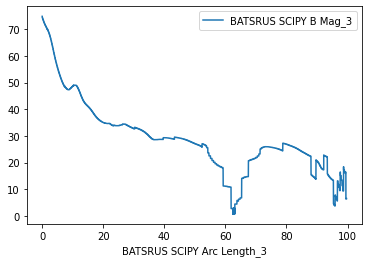

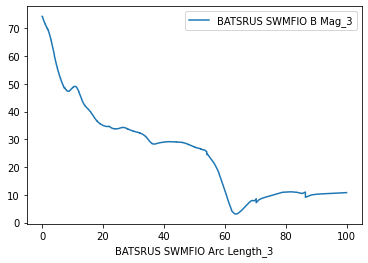

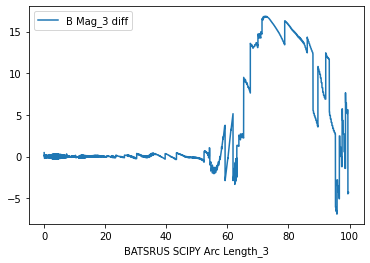

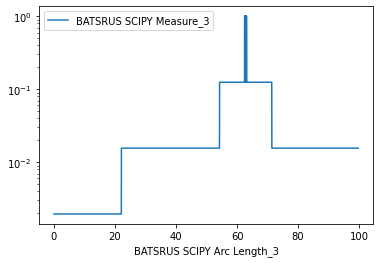

In [6]:
results.plot('BATSRUS SCIPY Arc Length_3','BATSRUS SCIPY B Mag_3')
results.plot('BATSRUS SWMFIO Arc Length_3','BATSRUS SWMFIO B Mag_3')
results['B Mag_3 diff'] = results['BATSRUS SCIPY B Mag_3'] - results['BATSRUS SWMFIO B Mag_3']
results.plot('BATSRUS SCIPY Arc Length_3','B Mag_3 diff')
results.plot('BATSRUS SCIPY Arc Length_3','BATSRUS SCIPY Measure_3', logy = True)

To illustrate the consequences, below is a 3D plot of the solutions from the two methods.  Both field lines start at (-3,0,0) in the front corner of the plot.  Initially, they overlap and the distance between the two field lines is small.  However, the field lines diverge significantly in the middle of the plot.  

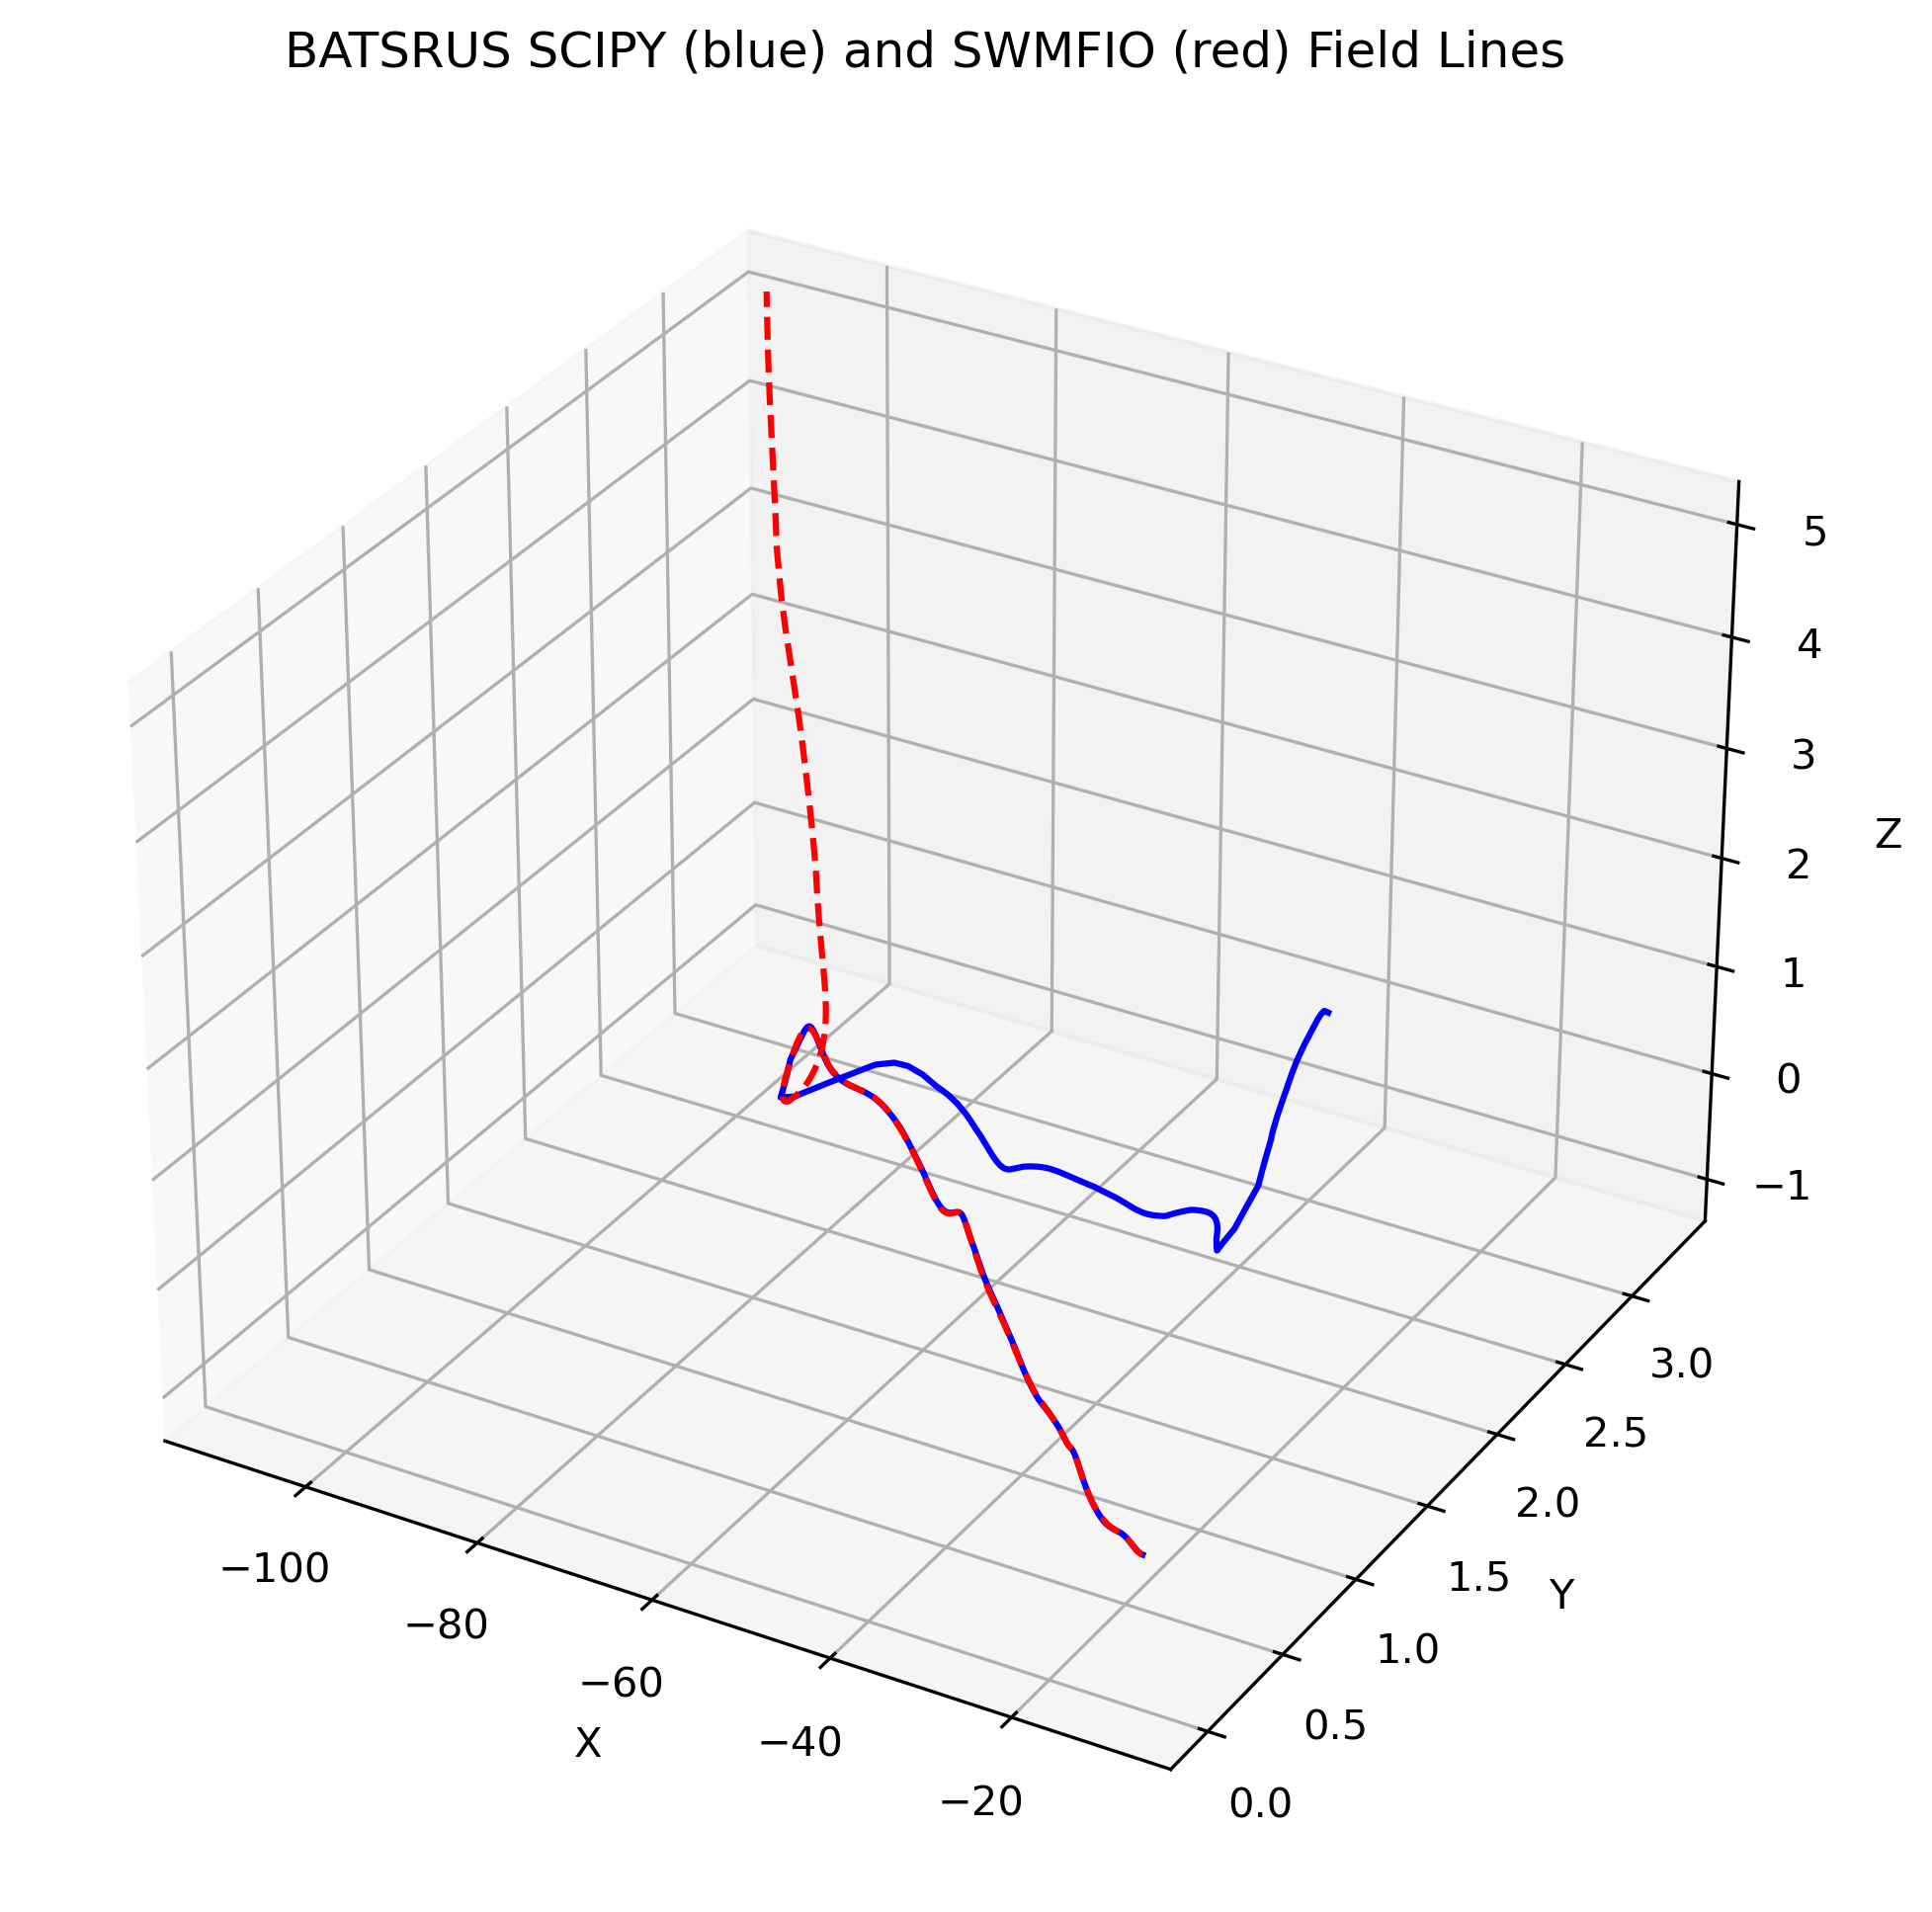

In [7]:
fig = plt.figure(figsize=(8,8), dpi=300)
ax = plt.axes(projection='3d')
ax.set_title('BATSRUS SCIPY (blue) and SWMFIO (red) Field Lines')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.plot( results['BATSRUS SCIPY Field Line_3_x'], results['BATSRUS SCIPY Field Line_3_y'], 
        results['BATSRUS SCIPY Field Line_3_z'], color='blue' )

ax.plot( results['BATSRUS SWMFIO Field Line_3_x'], results['BATSRUS SWMFIO Field Line_3_y'], 
        results['BATSRUS SWMFIO Field Line_3_z'], color='red', linestyle='dashed' )

To understand whether we see similar trends in the first three field lines, plots for them are shown below.  For each field line we show the differences between the magnetic fields (BATRSUS SCIPY versus BASTRUS SWMFIO, *aka* B Mag_n diff) and the cell size (measure) as a function of arc length.  As we saw above, the BATSRUS SCIPY and BATSRUS SWMFIO give similar results for the first three field lines.  Although the  three field lines are close, they are also shorter than the fourth field line, which reaches an arc length of 100.  And as with the fourth field line,we see some divergence in the B field interpolation at larger arc lengths.  Although the deviations oscillate in sign, likely causing some cancellation of the differences. For all three field lines, the cells (measure) is small.

<AxesSubplot:xlabel='BATSRUS SCIPY Arc Length_2'>

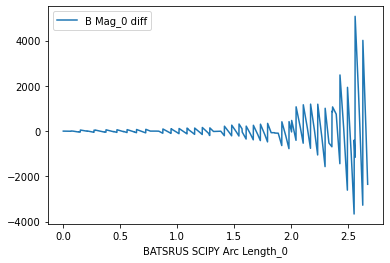

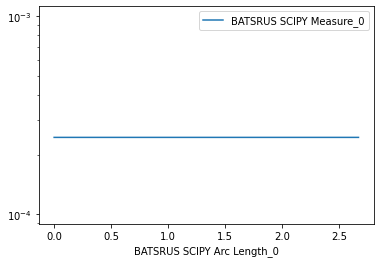

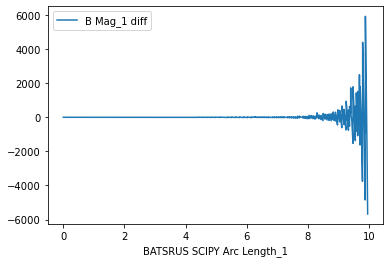

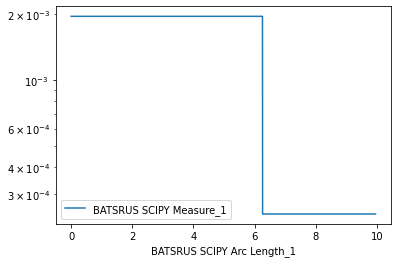

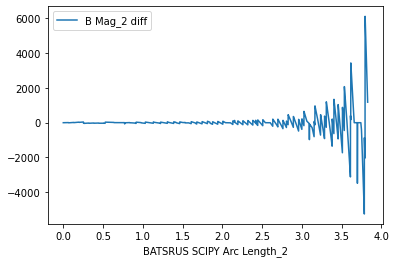

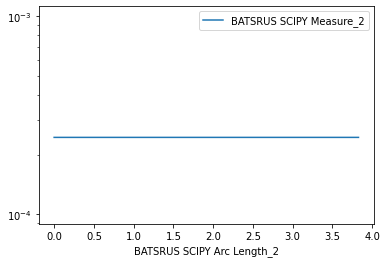

In [8]:
results['B Mag_0 diff'] = results['BATSRUS SCIPY B Mag_0'] - results['BATSRUS SWMFIO B Mag_0']
results.plot('BATSRUS SCIPY Arc Length_0','B Mag_0 diff')
results.plot('BATSRUS SCIPY Arc Length_0','BATSRUS SCIPY Measure_0', logy = True)
results['B Mag_1 diff'] = results['BATSRUS SCIPY B Mag_1'] - results['BATSRUS SWMFIO B Mag_1']
results.plot('BATSRUS SCIPY Arc Length_1','B Mag_1 diff')
results.plot('BATSRUS SCIPY Arc Length_1','BATSRUS SCIPY Measure_1', logy = True)
results['B Mag_2 diff'] = results['BATSRUS SCIPY B Mag_2'] - results['BATSRUS SWMFIO B Mag_2']
results.plot('BATSRUS SCIPY Arc Length_2','B Mag_2 diff')
results.plot('BATSRUS SCIPY Arc Length_2','BATSRUS SCIPY Measure_2', logy = True)

So far, we have not discussed the last method, VTK PARA, so we compare BATSRUS SCIPY and the VTK PARA methods.  As above we plot the differences between the methods (BATSRUS SCIPY VTK PARA Delta_n) versus arc length.  We see the differences are small for all four field lines.  We do not see the divergence in the the fourth field line, but it is shorter in the VTK PARA method.  It is about 20 arc length long, so we never have the opportunity to see whether the field lines diverge at arc lengths greater than 60. 

<AxesSubplot:xlabel='BATSRUS SCIPY VTK PARA Delta Arc Lengths_3'>

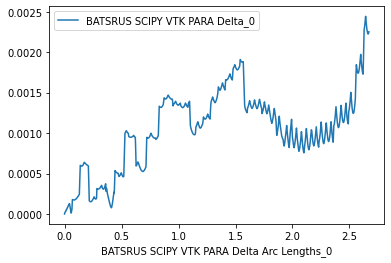

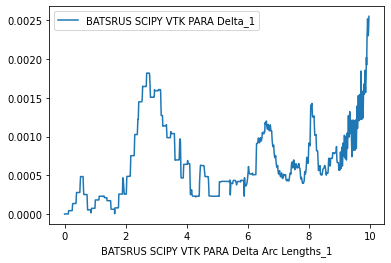

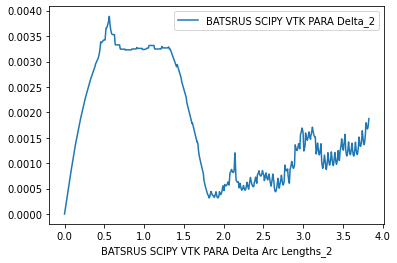

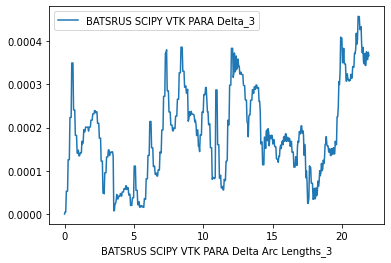

In [9]:
results.plot('BATSRUS SCIPY VTK PARA Delta Arc Lengths_0','BATSRUS SCIPY VTK PARA Delta_0')
results.plot('BATSRUS SCIPY VTK PARA Delta Arc Lengths_1','BATSRUS SCIPY VTK PARA Delta_1')
results.plot('BATSRUS SCIPY VTK PARA Delta Arc Lengths_2','BATSRUS SCIPY VTK PARA Delta_2')
results.plot('BATSRUS SCIPY VTK PARA Delta Arc Lengths_3','BATSRUS SCIPY VTK PARA Delta_3')

We see similar results from the BATSRUS SWMFIO and VTK PARA methods, but again the short arc length of the fourth VTK PARA field line does not allow us to see whether they diverge at large arc lengths.

<AxesSubplot:xlabel='BATSRUS SWMFIO VTK PARA Delta Arc Lengths_3'>

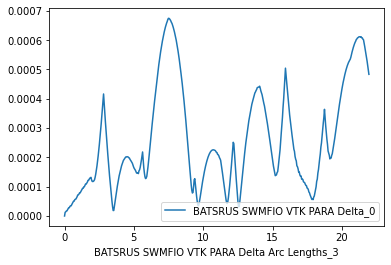

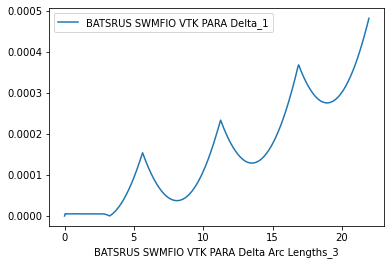

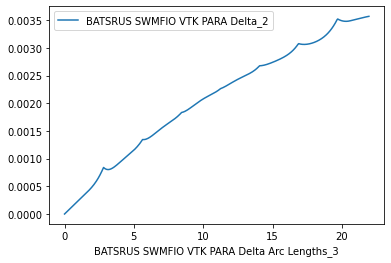

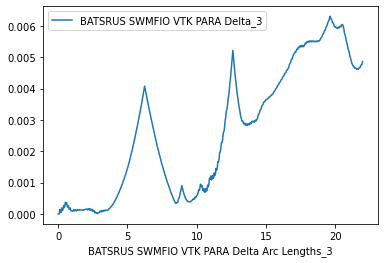

In [10]:
results.plot('BATSRUS SWMFIO VTK PARA Delta Arc Lengths_3','BATSRUS SWMFIO VTK PARA Delta_0')
results.plot('BATSRUS SWMFIO VTK PARA Delta Arc Lengths_3','BATSRUS SWMFIO VTK PARA Delta_1')
results.plot('BATSRUS SWMFIO VTK PARA Delta Arc Lengths_3','BATSRUS SWMFIO VTK PARA Delta_2')
results.plot('BATSRUS SWMFIO VTK PARA Delta Arc Lengths_3','BATSRUS SWMFIO VTK PARA Delta_3')

Note, I should include some summary statistics on the differences between the different methods, but I'm not sure what would be most informative.  I lean toward standard deviation between two methods with the results divided into arc length bins.  For example, Std Dev across all four field lines for the arc length 0-1, arc length 1-2, 3-4, etc.  Better ideas?
